# Static sequence imitiation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import gymnasium as gym

from stable_baselines3 import DQN, PPO, A2C, DDPG, SAC, TD3, HER
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

import optuna

import os
import time
import pickle
import sys
sys.path.append('../src/')

2025-11-05 15:02:23.187584: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-05 15:02:23.193094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762376543.199691   36175 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762376543.201870   36175 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762376543.207245   36175 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
from utils import save_results, load_results

# Simulate data

In [3]:
Nf = 20
nv_max = 2
random.seed(2)
true_sequence = np.array([np.full(nv_max, i) for i in range(Nf)]).flatten()
true_sequence = true_sequence.tolist()
random.shuffle(true_sequence)
print(true_sequence)

[13, 2, 19, 13, 17, 7, 14, 4, 17, 15, 15, 12, 3, 14, 3, 11, 0, 0, 4, 12, 7, 8, 5, 16, 18, 6, 10, 16, 18, 10, 9, 1, 6, 8, 9, 5, 11, 19, 2, 1]


# Set up environment

In [4]:
from gymnasium.spaces import Dict, Box, Discrete

from typing import Optional
import numpy as np


class SimpleTelEnv(gym.Env):
    def __init__(self, Nf, target_sequence, nv_max, off_by_lim):
        self.Nf = Nf # number of fields
        # self.T = 1 # 28800sec = 8hrs
        self.nv_max = nv_max
        self.target_sequence = target_sequence
        self.off_by_lim = off_by_lim
        # "Teff_meas": Box(0, 1, shape=(Nf,), dtype=np.float32),

        #TODO
        # Initialize positions - will be set in reset()
        self._field_id = -1
        # self._t = -1
        self._nvisits = np.full(shape=(Nf,), fill_value=-1, dtype=np.int32)
        # self._Teff_pred = np.full(shape=(Nf,), fill_value=-1, dtype=np.float32)
        self._index = -1
        self._sequence = []

        # self._possible_actions = [i for i in range(Nf)]

        #TODO
        # Define what the agent can observe
        # Dict space gives us structured, human-readable observations
        self.observation_space = gym.spaces.Dict(
            {
                # "t": Box(0, T, shape=None, dtype=np.float32),
                "field_id": Discrete(n=Nf, start=0),
                "nvisits": Box(0, 4, shape=(Nf,), dtype=np.int32),
                "index": Discrete(n=len(self.target_sequence), start=0)
                # "Teff_pred": Box(0, 1, shape=(Nf,), dtype=np.float32),
                    #filter
            }
        )
        
        # # Map action numbers to field
        self._action_to_field_id = {i:i for i in range(Nf)}

        self.action_space = gym.spaces.Discrete(self.Nf)

        # remove fields that have 
        
    def _get_obs(self):
        """Convert internal state to observation format.
    
        Returns:
            dict: Observation with agent and target positions
        """
        return {
            # "t": self._t,
            "field_id": self._field_id,
            "nvisits": self._nvisits,
            "index": self._index
            # "Teff_pred": self._Teff_pred,
        }

    def _get_info(self, chosen_field_id=None, correct=None):
        """Compute auxiliary information for debugging.

        Returns:
            
        """
        return {'chosen_field_id': chosen_field_id, 'correct': correct}

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        """Start a new episode.

        Args:
            seed: Random seed for reproducible episodes
            options: Additional configuration (unused in this example)

        Returns:
            tuple: (observation, info) for the initial state
        """
        # IMPORTANT: Must call this first to seed the random number generator
        super().reset(seed=seed)

        # initialize number of visits
        self._nvisits = np.full(shape=(self.Nf,), fill_value=0, dtype=np.int32)
        
        # Randomly choose initial field id and add 1 visit to nvisits list
        # self._field_id = int(self.np_random.integers(0, self.Nf, size=1, dtype=int)[0])
        self._field_id = self.target_sequence[0]
        # self._field_id = self.np_random.integers(0, self.Nf, size=1, dtype=int).tolist()[0]
        self._nvisits[self._field_id] += 1
        self._index = 0
        # self._t = np.array([0.0], dtype=np.float32)
        # self._Teff_pred = np.linspace(0.1, .98, num=self.Nf, dtype=np.float32)
        
        observation = self._get_obs()
        info = self._get_info()

        return observation, info

    def step(self, action):
        """Execute one timestep within the environment.

        Args:

        Returns:
        """
        # # choose random field for next observation
        # list_idx = self.np_random.integers(low=0, high=len(self._possible_actions), dtype=int)
        # proposed_field = self._possible_actions[list_idx]
        # self._nvisits[proposed_field] += 1
        # self._field_id = proposed_field
        self._index += 1            
        # get current field_id from action
        self._field_id = self._action_to_field_id[action]
        # add to nvisits
        self._nvisits[self._field_id] += 1

        # Simple reward structure: +1 for reaching target, 0 otherwise
        target_field = self.target_sequence[self._index]
        correct = self._field_id == target_field
        off_by_val = np.abs(self._field_id - target_field) <= 3
        if correct:
            reward = 1
        elif off_by_val:
            reward = .1
        else:
            reward = 0
            
        survey_complete = (self._index == len(self.target_sequence)-1)
        
        # end condition
        terminated = survey_complete
        truncated = False

        # get obs and info
        observation = self._get_obs()
        info = self._get_info(self._field_id, correct)

        return observation, reward, terminated, truncated, info

In [5]:
env_name = 'SimpleTel-v0'

In [6]:
# Register the environment so we can create it with gym.make()
gym.register(
    id=f"gymnasium_env/{env_name}",
    entry_point=SimpleTelEnv,
    max_episode_steps=300,  # Prevent infinite episodes. Here just set to 300 even though episode will terminate when stepping to last element of sequence
)

In [7]:
env = gym.make(f"gymnasium_env/{env_name}", Nf=Nf, target_sequence=true_sequence, nv_max=nv_max, off_by_lim=3)
# Create multiple environments for parallel training
# vec_env = gym.make_vec("gymnasium_env/SimpleTel-v0", num_envs=5, vectorization_mode='sync', Nf=Nf, target_sequence=true_sequence, nv_max=nv_max)


In [8]:
from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env.unwrapped)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment passes all checks!


In [9]:
OUTDIR = f'results/{env_name}/'
if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)
SEED = 20

In [10]:
# quick check to make sure environment is doing what's intended

# observation_list = []
# reward_list = []
# terminated_list = []
# truncated_list = []
# info_list = []

# observation, info = env.reset()
# observation_list.append(observation)
# reward_list.append(reward)

# for i in range(20):
#     try:
#         observation, reward, terminated, truncated, info = env.step(true_actions[i+1])
#         observation_list.append(observation)
#         reward_list.append(reward)
#         terminated_list.append(terminated)
#         truncated_list.append(truncated)
#         info_list.append(info)
#     except:
#         continue
# [observation_list[i]['field_id'] for i in range(len(observation_list))]

## How does model do with no training?

In [12]:

model_kwargs = {'policy': "MultiInputPolicy", "env": env, "verbose": True}
models = {'A2C': A2C, 'DQN':DQN, 'PPO':PPO} 
results = {model_name: {'model': model(**model_kwargs)} for model_name, model in models.items()}
results

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


{'A2C': {'model': <stable_baselines3.a2c.a2c.A2C at 0x749f9a828a10>},
 'DQN': {'model': <stable_baselines3.dqn.dqn.DQN at 0x749d838ae750>},
 'PPO': {'model': <stable_baselines3.ppo.ppo.PPO at 0x749d8298b290>}}

In [13]:
observation_list = np.empty(shape=(3, len(true_sequence)), dtype=dict)
reward_list = np.empty_like(observation_list)
terminated_list = np.empty_like(observation_list)
truncated_list = np.empty_like(observation_list)
info_list = np.empty_like(observation_list, dtype=dict)

In [14]:
for j, (name, model_dict) in enumerate(results.items()):
    obs, info = env.reset(seed=SEED)
    observation_list[j, 0] = obs
    info_list[j, 0] = info
    for i in range(len(true_sequence)):
        action, _states = model_dict['model'].predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action.tolist())
        observation_list[j,i+1] = obs
        info_list[j, i+1] = info
        reward_list[j, i] = reward
        terminated_list[j, i] = terminated
        truncated_list[j, i] = truncated
        if terminated or truncated:
            print(i)
            break

38
38
38


In [15]:

for j, obs_list in enumerate(observation_list):
    proposed_survey = [observation_list[j, i]['field_id'] for i in range(len(observation_list[j]))]
    print(proposed_survey)

[13, 7, 8, 16, 19, 16, 16, 14, 14, 16, 14, 4, 16, 14, 14, 19, 19, 14, 14, 4, 19, 14, 14, 14, 14, 14, 4, 16, 4, 14, 19, 14, 14, 14, 4, 4, 4, 4, 4, 4]
[13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
[13, 1, 15, 1, 15, 5, 6, 15, 1, 5, 5, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 7, 12, 7, 12, 7, 12, 7, 12, 6, 12]


In [16]:
print(true_sequence)

[13, 2, 19, 13, 17, 7, 14, 4, 17, 15, 15, 12, 3, 14, 3, 11, 0, 0, 4, 12, 7, 8, 5, 16, 18, 6, 10, 16, 18, 10, 9, 1, 6, 8, 9, 5, 11, 19, 2, 1]


## Now train and predict

In [17]:
OUTDIR, env_name

('results/SimpleTel-v0/', 'SimpleTel-v0')

In [19]:
for name in results.keys():
    file_path = OUTDIR + env_name + f'_{name}'
    try:
        results[name]['model'] = results[name]['model'].load(file_path, env=env)
    except:
        t_start = time.time()
        results[name]['model'].learn(total_timesteps=50000, log_interval=10)
        t_stop = time.time()
        results[name]['train_time'] = t_stop - t_stop
        results[name]['model'].save(path=file_path)
        

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [20]:
observation_list = np.empty(shape=(3, len(true_sequence)), dtype=dict)
reward_list = np.empty_like(observation_list)
terminated_list = np.empty_like(observation_list)
truncated_list = np.empty_like(observation_list)
info_list = np.empty_like(observation_list, dtype=dict)

In [21]:
for j, (name, model_dict) in enumerate(results.items()):
    obs, info = env.reset(seed=SEED)
    observation_list[j, 0] = obs
    info_list[j, 0] = info
    for i in range(len(true_sequence)):
        action, _states = results[name]['model'].predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action.tolist())
        observation_list[j,i+1] = obs
        info_list[j, i+1] = info
        reward_list[j, i] = reward
        terminated_list[j, i] = terminated
        truncated_list[j, i] = truncated
        if terminated or truncated:
            print(i)
            break

38
38
38


In [22]:
proposed_survey = np.empty_like(observation_list)
for j, obs_list in enumerate(observation_list):
    proposed_survey[j] = [observation_list[j, i]['field_id'] for i in range(len(observation_list[j]))]


In [23]:
print(proposed_survey)

[[13 13 13 13 13 13 13 13 13 13 13 13 3 13 3 13 13 13 13 13 13 13 5 13 13
  3 13 13 13 13 13 3 3 13 13 5 13 13 3 3]
 [13 0 19 12 17 7 14 4 17 14 12 12 3 14 3 11 0 0 4 12 7 8 5 16 18 6 10 16
  18 10 9 0 6 8 9 5 11 19 2 1]
 [13 2 19 13 17 7 14 4 17 15 15 12 3 14 3 17 15 7 4 12 7 8 5 16 18 8 8 16
  18 8 9 1 1 8 9 5 1 19 2 1]]


In [24]:
print(true_sequence)

[13, 2, 19, 13, 17, 7, 14, 4, 17, 15, 15, 12, 3, 14, 3, 11, 0, 0, 4, 12, 7, 8, 5, 16, 18, 6, 10, 16, 18, 10, 9, 1, 6, 8, 9, 5, 11, 19, 2, 1]


/tmp/ipykernel_15983/289756295.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,i].legend()


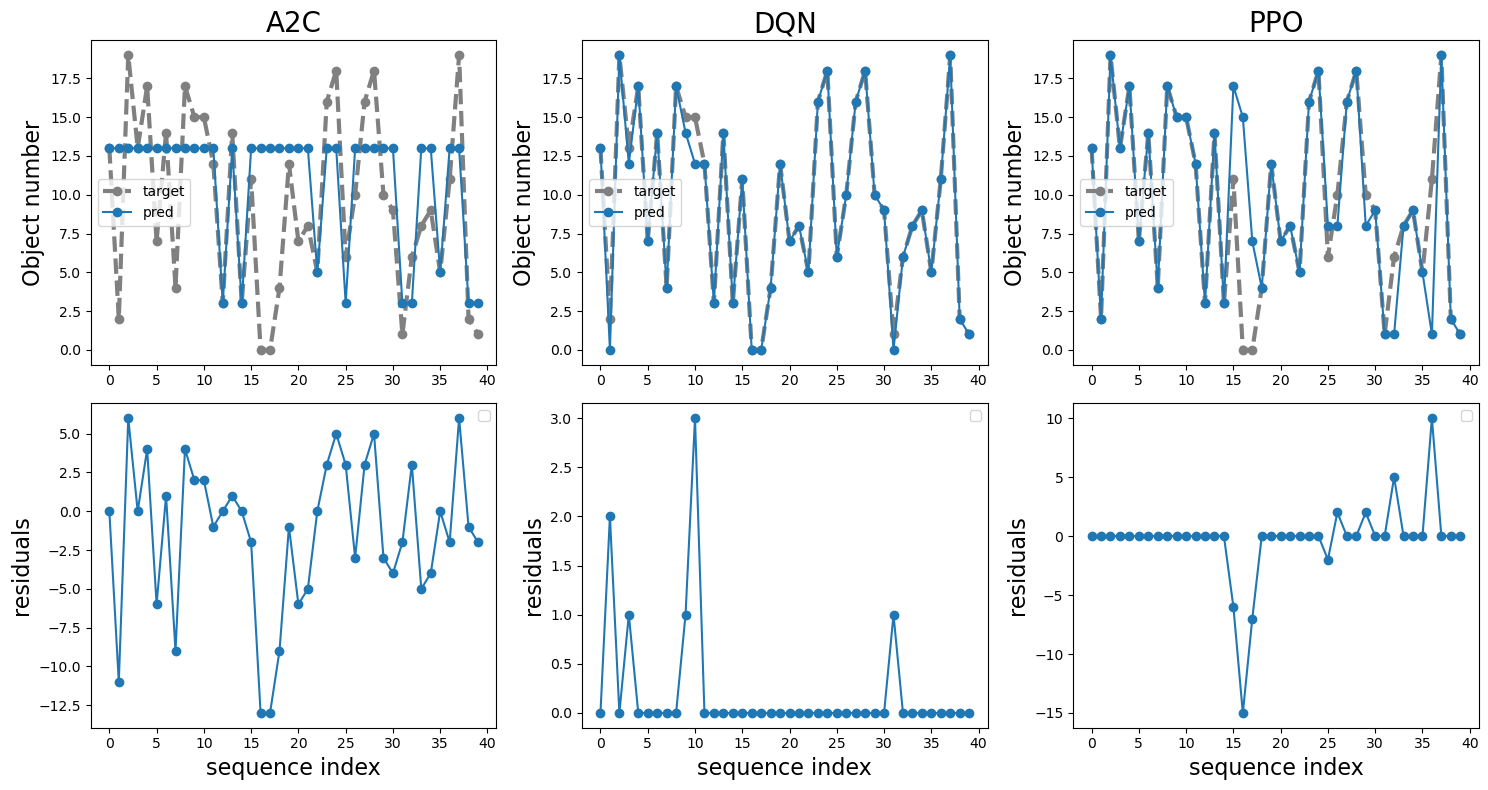

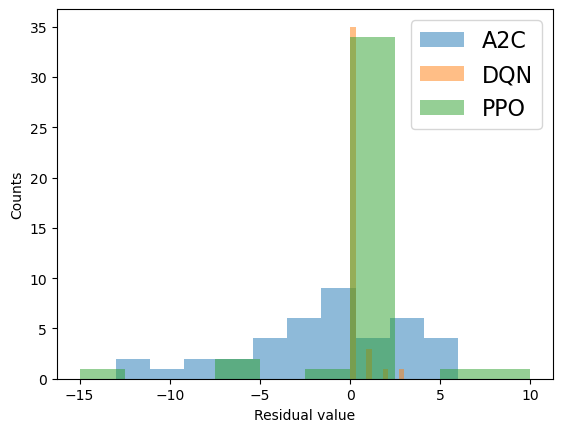

In [85]:
fig, axs = plt.subplots(2, 3, figsize=(15,8), sharex='row')
fig_hist, ax_hist = plt.subplots()
for i, model_name in enumerate(results.keys()):
    axs[0,i].set_title(model_name, fontsize=20)
    axs[0,i].plot(np.array(true_sequence), marker='o', label='target', color='grey', linestyle='dashed', lw=3)
    axs[0,i].plot(np.array(proposed_survey[i]), marker='o', label='pred')
    axs[0,i].legend()
    axs[0,i].set_ylabel('Object number', fontsize=16)

    residuals = np.array(true_sequence) - np.array(proposed_survey[i])
    axs[1,i].plot(residuals, marker='o')
    axs[1,i].legend()
    axs[1, i].set_xlabel('sequence index', fontsize=16)
    axs[1,i].set_ylabel('residuals', fontsize=16)
    
    ax_hist.hist(residuals, label=model_name, alpha=.5)
    ax_hist.set_xlabel('Residual value')
    ax_hist.set_ylabel('Counts')
    ax_hist.legend(fontsize=16)
fig.tight_layout()
    
# fig.savefig(OUTDIR + '')

In [25]:
n_episodes = 50
rewards = np.empty(shape=(len(true_sequence), n_episodes))
for i, model_name in enumerate(results.keys()):
    mean, std = evaluate_policy(results[model_name]['model'], Monitor(env), n_eval_episodes=n_episodes, deterministic=False)
    rewards[i], epsiodes = evaluate_policy(results[model_name]['model'], Monitor(env), n_eval_episodes=n_episodes, return_episode_rewards=True, deterministic=False)
    print(model_name, ":mean =", f"{mean:.2f}", ', std = ', f"{std:.2f}")

A2C :mean = 6.68 , std =  0.13
DQN :mean = 32.76 , std =  1.25
PPO :mean = 23.06 , std =  2.21


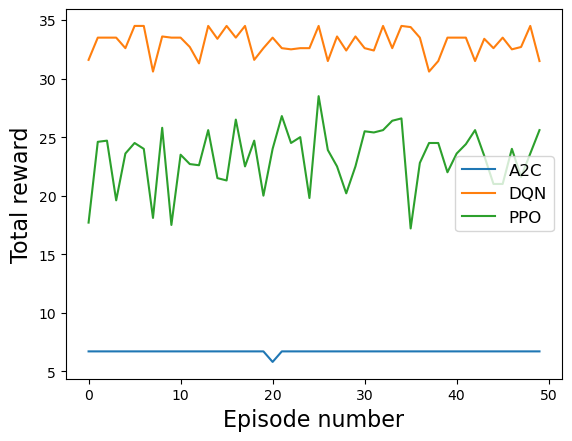

In [26]:
for i, model_name in enumerate(results.keys()):
    plt.plot(rewards[i], label=model_name)
plt.xlabel('Episode number', fontsize=16)
plt.ylabel('Total reward', fontsize=16)
plt.legend(fontsize=12)